In [1]:
#import packages
import numpy as np
import copy
import pandas
import os
import imp
import pickle
from scipy.interpolate import interp1d
import warnings
import time
import matplotlib.pyplot as plt
import inspect
import types
import math as mat
import seaborn as sns
import matplotlib.gridspec as gridspec
from matplotlib.colors import LogNorm
import datetime
from matplotlib import animation
from IPython.display import HTML
from tempfile import NamedTemporaryFile
import matplotlib.backends.backend_pdf
from scipy import interpolate
from itertools import groupby
import re
import csv
import copy
from fnmatch import fnmatch
import json
import h5py 
import copy
import math
import sys
import itertools
pi = math.pi

sys.path.append("/Users/fponce/Documents/vdesert/vdesert_funcs/") 
import plot_funcs.mpl_functions as mpl
from scipy.signal import butter,filtfilt

sns.set()
sns.set_style()
%matplotlib inline

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import analysis_funcs.saccade_ider as fs
import analysis_funcs.saccade_ider_n_plot as fs_pt

In [3]:
#filter angles and dejitter functions

def butter_lowpass(th_order=4, highcut=260, fs=32.):

    nyq = 0.5 * fs
    high = highcut / nyq
    return butter(th_order, high, btype='low')

def filtTrace(inArr, fs):

    th_order, highcut = 4, 9.#highcut is 6 based of Maimons paper, could be up to 9
    d, c = butter_lowpass(th_order, highcut, fs)
    return filtfilt(d, c, inArr)

#deJitter function
def deJit(inArr, dJit=True, threshJit=5.):    # If kinefly jumps more than threshJit compared to samples before and after, then take the average of before and after.
    # import numpy as np #uncomment if numpy had not been imported yet.
    inArrdeJit = np.copy(inArr)
    count = 0
    if dJit:    
        for idx in range (1,len(inArr)-1): # 1 frame jitter, comp. to prev and next
            if abs(inArr[idx]-inArr[idx-1])>threshJit and abs(inArr[idx+1]-inArr[idx])>threshJit:
                count = count + 1
                inArrdeJit[idx] = np.mean((inArrdeJit[idx-1],inArrdeJit[idx+1]))
        for idx in range (2,len(inArr)-2): # 2 frames jitter, comp. to prev and next+1
            if abs(inArr[idx]-inArr[idx-1])>threshJit and abs(inArr[idx+2]-inArr[idx])>threshJit:
                count = count + 1
                inArrdeJit[idx] = np.mean((inArrdeJit[idx-1],inArrdeJit[idx+2]))
        for idx in range (2,len(inArr)-2): # 2 frame jitter, comp. to prev-1 and next
            if abs(inArr[idx]-inArr[idx-2])>threshJit and abs(inArr[idx+1]-inArr[idx])>threshJit:
                count = count + 1
                inArrdeJit[idx] = np.mean((inArrdeJit[idx-2],inArrdeJit[idx+1]))
        # the following three for-loops can be commented to only dejitter based on nearest frame jumps
        for idx in range (2,len(inArr)-2): # 3 frame jitter, comp. to prev-1 and next+1
            if abs(inArr[idx]-inArr[idx-2])>threshJit and abs(inArr[idx+2]-inArr[idx])>threshJit:
                count = count + 1
                inArrdeJit[idx] = np.mean((inArrdeJit[idx-2],inArrdeJit[idx+2]))
        for idx in range (1,len(inArr)-3): # 3 frame jitter, comp. to prev and next+2
            if abs(inArr[idx]-inArr[idx-1])>threshJit and abs(inArr[idx+3]-inArr[idx])>threshJit:
                count = count + 1
                inArrdeJit[idx] = np.mean((inArrdeJit[idx-1],inArrdeJit[idx+3]))
        for idx in range (3,len(inArr)-1): # 3 frame jitter, comp. to prev-2 and next
            if abs(inArr[idx]-inArr[idx-3])>threshJit and abs(inArr[idx+1]-inArr[idx])>threshJit:
                count = count + 1
                inArrdeJit[idx] = np.mean((inArrdeJit[idx-3],inArrdeJit[idx+1]))
    pct = 100 * count / len(inArr)
    msg = str(count) + ' out of ' + str(len(inArr)) + ' samples were treated as jitter (' + str(pct)[0:4] +' %)'
    return inArrdeJit, msg

In [4]:
#import data from pickles

pickle_path = "/Users/fponce/Documents/vdesert/VD_031320/VD_031320.p"

all_exp_data = pickle.load(open( pickle_path, "rb" ) )

datapaths = all_exp_data[0]
allangles_vf = all_exp_data[1]
all_start_frames_m = all_exp_data[2]
all_end_frames_m = all_exp_data[3]
print(len(datapaths))
print(len(allangles_vf))
print(len(datapaths))

6
6
6


In [5]:
# #plotting
# sns.set_style("ticks")
# tp = [5,6,7]
# bckclr_labels = ['darkseagreen', 'lavender','lightyellow']
# myc = ["red", "medium green", "denim blue"]
# for j in range(len(tp)):
#     fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
#     for i in range(len(allangles_vf)): 
#         p = allangles_vf[i][all_start_frames_m[i][tp[j]]:all_end_frames_m[i][tp[j]]]

#         ax1.plot((0,21600), (0,0), 'r', linewidth= 2)

#         mycolor = list(np.random.choice(range(256), size=3))
#         plt.scatter(np.arange(len(p)), p, c=sns.xkcd_rgb['black'], alpha=0.1, s=10)#,'k',alpha= 0.5)
#         ax1.set_title(j)
#         ax1.set_ylim([-200, 200])
#         ax1.set_xlim([0, (len(p))])
        
# #         ax1.set_xticks(np.arange(0, 5401, 1800))
#         ax1.set_yticks(np.arange(-180, 225,45))
#         ax1.yaxis.set_tick_params(labelsize=20)
#         ax1.xaxis.set_tick_params(labelsize=20)
#         sns.despine()
#         ax1.tick_params(direction='in', length=8, width=2)
#         sns.despine(offset=10, trim=False);
#         ax1.spines['left'].set_linewidth(2)
#         ax1.spines['bottom'].set_linewidth(2)
#         ax1.grid(True,linewidth=2)  

In [6]:
#done in first notebook
#unwrap before dijitter
#first dejitter 
#then resample

#done here
#then filter
#saccade find it

In [7]:
#filter angles
allangles_vf_filt1 = []
for i in range(len(allangles_vf)):
    flyAngle_r = allangles_vf[i]
    #low-pass filtered
    flyAngleFilt = filtTrace(flyAngle_r, 30)
    #dejitter                   
    flyAngle_jit = np.rad2deg(np.unwrap(np.deg2rad(flyAngleFilt), discont = np.pi))
    flyAngle, msg = deJit(flyAngle_jit, dJit=True, threshJit=45.)       
    a = np.arctan2(np.sin(np.deg2rad(flyAngle)), np.cos(np.deg2rad(flyAngle)))
    allangles_vf_filt1.append(np.rad2deg(a))

In [8]:
#filter angles again!!
allangles_vf_filt = []
for i in range(len(allangles_vf)):
    flyAngle_r = allangles_vf_filt1[i]
    #low-pass filtered
    flyAngleFilt = filtTrace(flyAngle_r, 30)
    #dejitter                   
    flyAngle_jit = np.rad2deg(np.unwrap(np.deg2rad(flyAngleFilt), discont = np.pi))
    flyAngle, msg = deJit(flyAngle_jit, dJit=True, threshJit=45.)       
    a = np.arctan2(np.sin(np.deg2rad(flyAngle)), np.cos(np.deg2rad(flyAngle)))
    allangles_vf_filt.append(np.rad2deg(a))

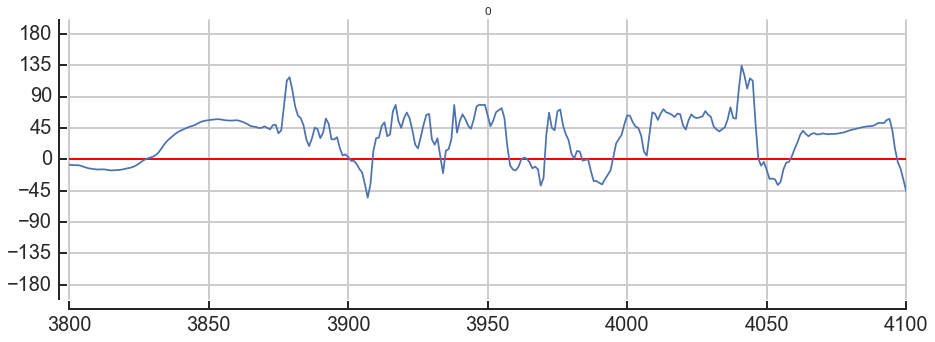

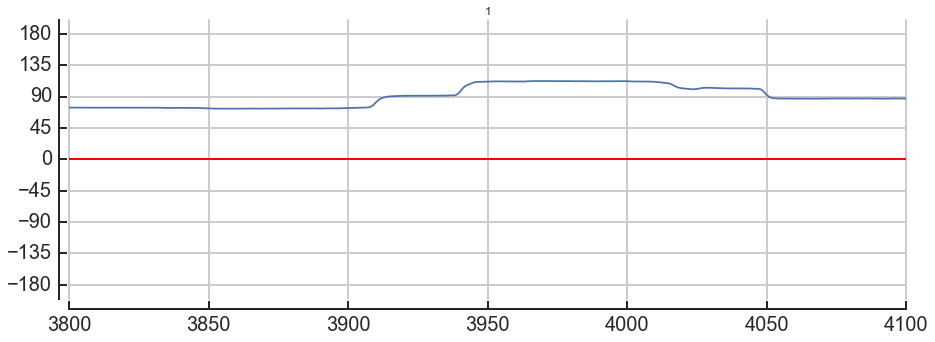

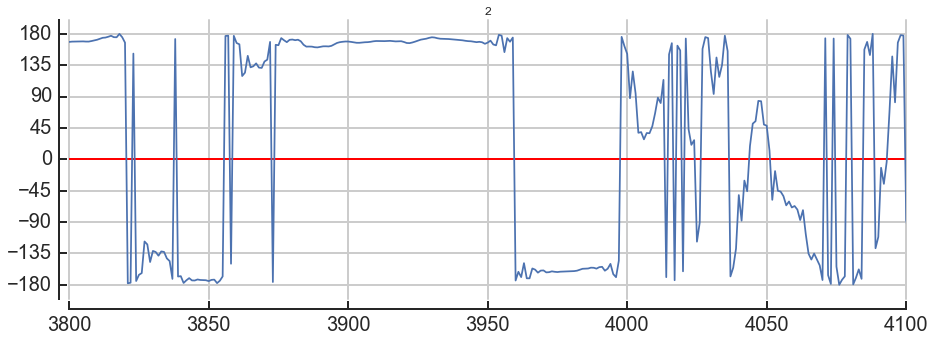

In [9]:
#plotting easier to see single traces
sns.set_style("ticks")
tp = [5,6,7]
bckclr_labels = ['darkseagreen', 'lavender','lightyellow']
myc = ["red", "medium green", "denim blue"]
for j in range(len(tp)):
    fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
    for i in [5]:#range(len(allangles_vf)): 
        p = allangles_vf_filt[i][all_start_frames_m[i][tp[j]]:all_end_frames_m[i][tp[j]]]

        ax1.plot((0,21600), (0,0), 'r', linewidth= 2)

        mycolor = list(np.random.choice(range(256), size=3))
        #plt.scatter(np.arange(len(p)), p, c=sns.xkcd_rgb['black'], alpha=0.1, s=10)#,'k',alpha= 0.5)
        plt.plot(p)
        
        ax1.set_title(j)
        ax1.set_ylim([-200, 200])
        ax1.set_xlim([0, (len(p))])
        ax1.set_xlim([3800, 4100])
        
#         ax1.set_xticks(np.arange(0, 5401, 1800))
        ax1.set_yticks(np.arange(-180, 225,45))
        ax1.yaxis.set_tick_params(labelsize=20)
        ax1.xaxis.set_tick_params(labelsize=20)
        sns.despine()
        ax1.tick_params(direction='in', length=8, width=2)
        sns.despine(offset=10, trim=False);
        ax1.spines['left'].set_linewidth(2)
        ax1.spines['bottom'].set_linewidth(2)
        ax1.grid(True,linewidth=2)

In [10]:
#plotting dot plots
# sns.set_style("ticks")
# tp = [5,6,7]
# bckclr_labels = ['darkseagreen', 'lavender','lightyellow']
# myc = ["red", "medium green", "denim blue"]
# for j in range(len(tp)):
#     fig, ax1 = plt.subplots(1,1,figsize=(15, 5))
#     for i in range(len(allangles_vf)): 
#         p = allangles_vf_filt[i][all_start_frames_m[i][tp[j]]:all_end_frames_m[i][tp[j]]]

#         ax1.plot((0,21600), (0,0), 'r', linewidth= 2)

#         #ax1.plot((0,5400), (b, b), 'gold', linewidth= 4)
# #         if j in [1,4]:
# #             ax1.plot((0,5400), (0, 0), 'yellow', linewidth= 4)
# #         else:
# #             pass
#         mycolor = list(np.random.choice(range(256), size=3))
#         plt.scatter(np.arange(len(p)), p, c=sns.xkcd_rgb['black'], alpha=0.1, s=10)#,'k',alpha= 0.5)
#         ax1.set_title(j)
#         ax1.set_ylim([-200, 200])
#         ax1.set_xlim([0, (len(p))])
        
# #         ax1.set_xticks(np.arange(0, 5401, 1800))
#         ax1.set_yticks(np.arange(-180, 225,45))
#         ax1.yaxis.set_tick_params(labelsize=20)
#         ax1.xaxis.set_tick_params(labelsize=20)
#             #ax1.set_xticklabels((round(all_start_frames[j]/30),round(all_end_frames[j+1]/30)))
#             #box, ticks format
#         sns.despine()
#         ax1.tick_params(direction='in', length=8, width=2)
#         sns.despine(offset=10, trim=False);
#         ax1.spines['left'].set_linewidth(2)
#         ax1.spines['bottom'].set_linewidth(2)
#         ax1.grid(True,linewidth=2)
        
# #         if j in [0,3]:
# #             ax1.patch.set_facecolor(bckclr_labels[0])
# #         elif j in [1,4]:
# #             ax1.patch.set_facecolor(bckclr_labels[1])
# #         elif j in [2,5]:
# #             ax1.patch.set_facecolor(bckclr_labels[2])            
#         ax1.patch.set_alpha(0.7)

In [11]:
# all_start_frames_m, all_end_frames_m
# for i in range(len(allangles_vf_filt)):
#     print('--------------------------')
#     print(i)
#     for j in range(len(all_start_frames_m)):
#         print([all_start_frames_m[i][j],all_end_frames_m[i][j]])

In [12]:
#run saccade identifier for all exp

#path to save figs if True
sFigPath = '/Users/fponce/Documents/vdesert/VD_031320/'

all_SMagMx = []
all_SMagMn = []
all_SAmx = []
all_SAmn = []
all_SVmx = []
all_SVmn = []
all_headingVelo = []

for i in range(len(allangles_vf)):
    flyAngle_wr = allangles_vf_filt[i]
    flyAngle_s = np.rad2deg(np.unwrap(np.deg2rad(flyAngle_wr), discont = np.pi))
    SMagMx, SMagMn, SAmx, SAmn, SVmx, SVmn, headingVelo = fs.findSacs(flyAngle_s, i, sFigPath, False)
    all_SMagMx.append(SMagMx)
    all_SMagMn.append(SMagMn)
    all_SAmx.append(SAmx)
    all_SAmn.append(SAmn)
    all_SVmx.append(SVmx)
    all_SVmn.append(SVmn)
    all_headingVelo.append(headingVelo)

In [19]:
#plotting identified saccades, angular vel, angle, func
def pltSacs_1(flyAngle, fly_n, sFigPath, headingVelo, SVMxThr, SVMnThr, flyAngleFilt, SSctnMx, SSctnMn):

    a_wr_1 = np.arctan2(np.sin(np.deg2rad(flyAngle)), np.cos(np.deg2rad(flyAngle)))
    a_wr = (np.rad2deg(a_wr_1))
    
    #from mpl_functions import adjust_spines
    import matplotlib.pyplot as plt
    from matplotlib import gridspec
    
    sns.set_style("ticks")
    

    # # default values for saccade ider
    fVec, fs, headingVeloThresh, headingVeloCeil, magThresh, magCeil = \
    np.zeros_like(flyAngle),30., 60., 2500., 6., 180.


    timeCol = np.arange(len(flyAngle))
    sttT, endT = timeCol[0], timeCol[-1] # substitute if desired
    figure_padding = 0.25
    subplot_padding = 0.3
    kleur2 = 'black'
    lijnbreedte = .5
    WoverH = 2. # figure ratio: W/H

    headingVeloRange = 20 * headingVeloThresh

    yLimMin, yLimMax = np.nanmin(flyAngle[10:-10]), np.nanmax(flyAngle[10:-10])

    yLimMinPlt = yLimMin#-yRangeAdd

    figH = 10.
    figW = WoverH * figH
    fig = plt.figure(figsize=(15,15))
    fig.set_facecolor('w')

    aspect_ratio = (4+subplot_padding)/(12.+subplot_padding)
    
    gs0 = gridspec.GridSpec(3, 1, height_ratios=[2,2,2]) #width_ratios=[20,1,1,1],
    
#     gs0.update(left=figure_padding*aspect_ratio, right=1-figure_padding*aspect_ratio,
#                wspace=subplot_padding, hspace=subplot_padding,
#                top=1-figure_padding+subplot_padding, bottom=figure_padding-subplot_padding)
    
    ax0 = fig.add_subplot(gs0[0, :])
    ax2 = fig.add_subplot(gs0[1, :])
    ax3 = fig.add_subplot(gs0[2, :])
#     ax0 = plt.subplot(gs0[0, 0]) # headingVelo
#     ax2 = plt.subplot(gs0[1, 0]) # LmR and sacs
    
    #ax3 = plt.subplot(gs0[2, 0])

    #x= 0 line
    ax0.axhspan(0, 0, alpha=1, color='k', zorder=0, linewidth=.5*lijnbreedte)
    
    #threshhold lines angular velocities
    ax0.axhspan(headingVeloThresh, headingVeloThresh, linestyle='--',
                alpha=.5, color='k', zorder=0, linewidth=0.5)
    ax0.axhspan(-headingVeloThresh, -headingVeloThresh, linestyle='--',
                alpha=.5, color='k', zorder=0, linewidth=0.5)
    
    #headingVeloCeil might not show up in graph
    ax0.axhspan(headingVeloCeil, headingVeloCeil, linestyle=':',
                alpha=1, color='g', zorder=1, linewidth=1)
    ax0.axhspan(-headingVeloCeil, -headingVeloCeil, linestyle=':',
                alpha=1, color='k', zorder=1, linewidth=1)

    #angular velocity
    ax0.plot(timeCol, headingVelo, color='k', zorder=2, linewidth=lijnbreedte)
    ax0.plot(timeCol, SVMxThr, linestyle='None', marker='.', color='b', markersize=5, zorder=2)
    ax0.plot(timeCol, SVMnThr, linestyle='None', marker='.', color='r', markersize=5, zorder=2)

    #heading plotted in second graph
    ax2.plot(timeCol, flyAngle, color='k', zorder=1, linewidth=1)
    ax2.plot(timeCol, flyAngleFilt, color='g', zorder=1, linewidth=.5)
    
    #coloring the saccades in the heading in second plot
    ax2.plot(timeCol, SSctnMx, color='b', zorder=2, linewidth=1)
    ax2.plot(timeCol, SSctnMn, color='r', zorder=2, linewidth=1)

    #heading plotted in third graph
    ax3.plot(timeCol, a_wr, color='k', zorder=2, linewidth=1)
    ax3.axhspan(0, 0, alpha=1, color='g', zorder=1, linewidth=2)
#     ax3.plot(timeCol, flyAngleFilt, color='g', zorder=1, linewidth=.5)
    
    ##formatting##
    ax0.set_ylabel('ang. vel. ($^\circ$/s)', labelpad=0, fontname='Arial', fontsize = 16)
    #ax0.yaxis.set_label_position('right')
    ax0.set_xlim((sttT, endT))
    ax0.set_ylim((-headingVeloRange,headingVeloRange)) #data

    ax2.set_ylabel('angle unwr ($^\circ$)', labelpad=1, fontname='Arial', fontsize = 16)
    ax2.set_xlim((sttT, endT))
    ax2.set_ylim((yLimMinPlt,yLimMax)) #data
    
    ax3.set_ylabel('angle ($^\circ$)', labelpad=1, fontname='Arial', fontsize = 16)
    ax3.set_xlim((sttT, endT)) 
    ax3.set_ylim([-180, 180])
    ax3.set_yticks(np.arange(-180, 225,45))
    
    sns.despine()
    ax0.tick_params(direction='in', length=8, width=2)
    sns.despine(offset=10, trim=False);
    ax0.spines['left'].set_linewidth(2)
    ax0.spines['bottom'].set_linewidth(2)
    ax0.grid(True,linewidth=1)
    ax0.set_xticklabels([])
    ax0.yaxis.set_tick_params(labelsize=14)
    
    sns.despine()
    ax2.tick_params(direction='in', length=8, width=2)
    sns.despine(offset=10, trim=False);
    ax2.spines['left'].set_linewidth(2)
    ax2.spines['bottom'].set_linewidth(2)
    ax2.grid(True,linewidth=1)
    ax2.set_xticklabels([])
    ax2.yaxis.set_tick_params(labelsize=14)
    
    sns.despine()
    ax3.tick_params(direction='in', length=8, width=2)
    sns.despine(offset=10, trim=False);
    ax3.spines['left'].set_linewidth(2)
    ax3.spines['bottom'].set_linewidth(2)
    ax3.grid(True,linewidth=1)
    ax3.xaxis.set_tick_params(labelsize=14)
    ax3.yaxis.set_tick_params(labelsize=14)

    if not os.path.exists(sFigPath):
        #os.makedirs(sFigPath)
        print('fig directory does not exist')
    print ('figs can be found here: ' + sFigPath)


    #saving fig
    savePlotName = sFigPath + 'fly' + str(fly_n) +'_sac_t'+ '.png'
    fig.savefig(savePlotName , bbox_inches='tight', dpi = 1200)
    plt.close

figs can be found here: /Users/fponce/Documents/vdesert/VD_031320/


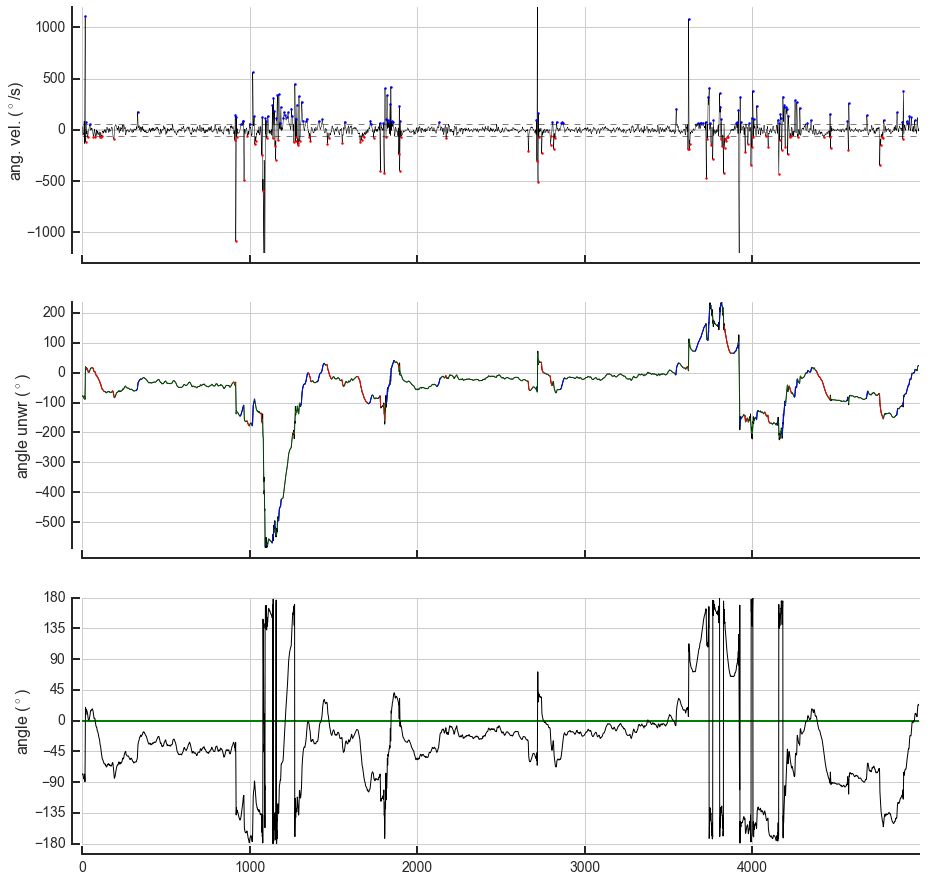

In [20]:
#run saccade identifier for single time bout (t)

#path to save figs if True
sFigPath_t = '/Users/fponce/Documents/vdesert/VD_031320/'

# all_SMagMx_t = []
# all_SMagMn_t = []
# all_SAmx_t = []
# all_SAmn_t = []
# all_SVmx_t = []
# all_SVmn_t = []
# all_headingVelo_t = []

for i in [0]:#range(len(allangles_vf)):
    j1 = 0
    j2 = 5000
    flyAngle_wr_t = allangles_vf_filt[i][j1:j2]
    flyAngle_s_t = np.rad2deg(np.unwrap(np.deg2rad(flyAngle_wr_t), discont = np.pi))
    
    SMagMx_t, SMagMn_t, SAmx_t, SAmn_t, SVmx_t, SVmn_t, headingVelo_t, SVMxThr_t, SVMnThr_t, \
    flyAngleFilt_t, SSctnMx_t, SSctnMn_t = fs_pt.findSacs_n_plot(flyAngle_s_t, i, sFigPath_t, False)

    pltSacs_1(flyAngle_s_t, i, sFigPath_t, headingVelo_t, SVMxThr_t, SVMnThr_t, flyAngleFilt_t,\
              SSctnMx_t, SSctnMn_t)
#     all_SMagMx_t.append(SMagMx)
#     all_SMagMn_t.append(SMagMn_t)
#     all_SAmx_t.append(SAmx_t)
#     all_SAmn_t.append(SAmn_t)
#     all_SVmx_t.append(SVmx_t)
#     all_SVmn_t.append(SVmn_t)
#     all_headingVelo_t.append(headingVelo_t)

In [67]:
#flyAngle_s #flyangle_s -> _s for saccades 

flyAngle_s = np.rad2deg(np.unwrap(np.deg2rad(flyAngle_wr), discont = np.pi))

pltSacs_1(flyAngle_t_uw, fly_n, sFigPath, headingVelo, SVMxThr, SVMnThr, flyAngleFilt, SSctnMx, SSctnMn)

NameError: name 'flyAngle_t_uw' is not defined

In [ ]:
#t = np.argwhere([~np.isnan(all_SVmx[0])])
# print((all_SVmx[0][0:25]))
print((all_SMagMx[0][0:25]))
print((all_SVmx[0][0:25]))
# print((all_SAmn[0][0:100]))

In [ ]:
#plotting func
sns.set_style("ticks")

def pltTrialMTSs(timeCol, HAF, HA, HV, SAmx, SAmn, findSaccades = True): #, HAF, HA, HV
    
    kleur2 = 'black'
    lijnbreedte = .6
    WoverH = 2. # figure ratio: W/H
    figH = 7.
    figW = WoverH * figH
    fig = plt.figure(figsize=(figW,figH))
    fig.set_facecolor('w')
    ax0 = fig.add_subplot(111)
    
    ax0.axhspan(0, 0, alpha=.5, color='k', zorder=3, linewidth=.5)
    #ax0.plot(timeCol, HAF, linestyle='None', marker='o', color='k', zorder=6, mec='none', ms=3)
    ax0.plot(timeCol, HAF, marker='o', color='k', zorder=2, mec='none', ms=3)
    ax0.plot(timeCol, HV/10., color='gray', zorder=1, linewidth=1)

    if findSaccades:
        ## Saccade ID overlays
        #sIdcs = np.argwhere(np.abs(SAmx[~np.isnan(SAmx)])>0)
        sIdcs = np.argwhere(np.abs(SAmx)>0)
        for sIdx in sIdcs:
            ax0.axvline(x=timeCol[sIdx], ymin=0., ymax=6., color='b', dashes=[1, 1], linewidth=lijnbreedte)
        sIdcs = np.argwhere(np.abs(SAmn)>0)
        for sIdx in sIdcs:
            ax0.axvline(x=timeCol[sIdx], ymin=0., ymax=6., color='r', dashes=[1, 1], linewidth=lijnbreedte)
                
    ax0.set_ylabel('Heading ($^\circ$)', labelpad=0, fontname='Arial', zorder=4, fontsize=20)
    ax0.set_xlabel('Frame', labelpad=10, fontname='Arial', zorder=4, fontsize=20)
    #ax0.set_xlim((sttT, endT))

    ax0.set_ylim([-180, 180])
    ax0.set_xlim([0, (len(p))])
    #ax0.set_xlim([7600, 8200])
    ax0.set_xlim([0, 1000])
    
    #ax0.set_xticks([ ])
    ax0.set_yticks(np.arange(-180, 225,45))
    ax0.yaxis.set_tick_params(labelsize=20)
    ax0.xaxis.set_tick_params(labelsize=20)

    sns.despine()
    ax0.tick_params(direction='in', length=8, width=2)
    sns.despine(offset=10, trim=False);
    ax0.spines['left'].set_linewidth(2)
    ax0.spines['bottom'].set_linewidth(2)
    #ax0.grid(True,linewidth=2)    
    ax0.grid(False,)
  
    plt.close

In [ ]:
for i in [5]:#range(len(allangles_vf)): 

    a = allangles_vf_filt[i]
    pltTrialMTSs(np.arange(len(a)), (a), a, all_headingVelo[i], \
                 all_SAmx[i], all_SAmn[i], findSaccades = True)   

In [16]:
#plotting func
sns.set_style("ticks")

def pltTrialMTSs(timeCol, HAF, HA, HV, SAmx, SAmn, findSaccades = True): #, HAF, HA, HV
    
    kleur2 = 'black'
    lijnbreedte = .6
    WoverH = 2. # figure ratio: W/H
    figH = 7.
    figW = WoverH * figH
    fig = plt.figure(figsize=(figW,figH))
    fig.set_facecolor('w')
    ax0 = fig.add_subplot(111)
    
    ax0.axhspan(0, 0, alpha=.5, color='k', zorder=3, linewidth=.5)
    #ax0.plot(timeCol, HAF, linestyle='None', marker='o', color='k', zorder=6, mec='none', ms=3)
    ax0.plot(timeCol, HAF, marker='o', color='k', zorder=2, mec='none', ms=3)
    ax0.plot(timeCol, HV/10., color='gray', zorder=1, linewidth=1)

    if findSaccades:
        ## Saccade ID overlays
        #sIdcs = np.argwhere(np.abs(SAmx[~np.isnan(SAmx)])>0)
        sIdcs = np.argwhere(np.abs(SAmx)>0)
        for sIdx in sIdcs:
            ax0.axvline(x=timeCol[sIdx], ymin=0., ymax=6., color='b', dashes=[1, 1], linewidth=lijnbreedte)
        sIdcs = np.argwhere(np.abs(SAmn)>0)
        for sIdx in sIdcs:
            ax0.axvline(x=timeCol[sIdx], ymin=0., ymax=6., color='r', dashes=[1, 1], linewidth=lijnbreedte)
                
    ax0.set_ylabel('Heading ($^\circ$)', labelpad=0, fontname='Arial', zorder=4, fontsize=20)
    ax0.set_xlabel('Frame', labelpad=10, fontname='Arial', zorder=4, fontsize=20)
    #ax0.set_xlim((sttT, endT))

#     ax0.set_ylim([-180, 180])
    ax0.set_xlim([0, (len(p))])
    #ax0.set_xlim([7600, 8200])
    ax0.set_xlim([0, 1000])
    
    #ax0.set_xticks([ ])
    #ax0.set_yticks(np.arange(-180, 225,45))
    ax0.yaxis.set_tick_params(labelsize=20)
    ax0.xaxis.set_tick_params(labelsize=20)

    sns.despine()
    ax0.tick_params(direction='in', length=8, width=2)
    sns.despine(offset=10, trim=False);
    ax0.spines['left'].set_linewidth(2)
    ax0.spines['bottom'].set_linewidth(2)
    #ax0.grid(True,linewidth=2)    
    ax0.grid(False,)
  
    plt.close

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


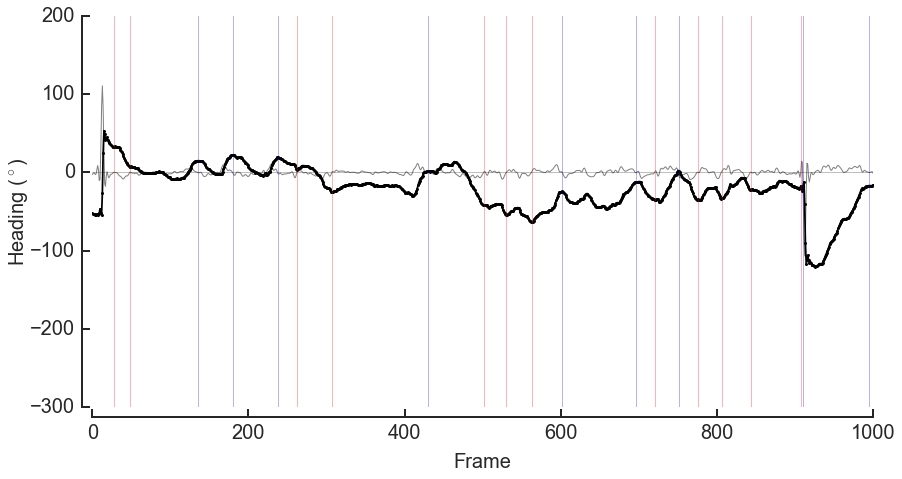

In [16]:
for i in [5]:#range(len(allangles_vf)): 

    a = np.unwrap(np.deg2rad(allangles_vf_filt[i]))
    pltTrialMTSs(np.arange(len(a)), (np.deg2rad(a), a, all_headingVelo[i], \
                 all_SAmx[i], all_SAmn[i], findSaccades = True)